<a href="https://colab.research.google.com/github/codingercat/machine-learning-projects/blob/main/Minipong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Minipong:
In this assignment we work with data and a simulation of a simple version of “pong”.
Two objects appear on the field: a + object as “ball”, and a − paddle that can take
different spots, but only in the bottom row. Pixels of the two objects are represented
with different the values −1 and 1 while background pixels have the value 0. The two
markers at the top corners are fixed (−1 and +1, respectively) and appear in every frame.
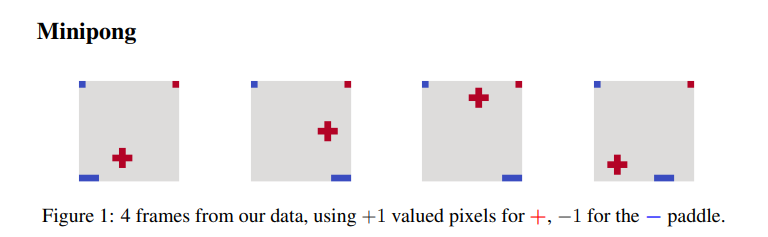

**Preparation**:

Download the Minipong.py and sprites.py python files. The
class Minipong.py implements the pong game simulation. Running sprites.py
will create datasets of pong screenshots for your first task.
A new pong game can be created like here:
from minipong import Minipong
pong = Minipong(level=1, size=5)
In this, level sets the information a RL agent gets from the environment, and size sets
the size of the game (in number of different paddle positions). Both paddle and + are 3
pixels wide, and cannot leave the field. A game of size 5 is (15×15) pixels, and the ball
x- and y-coordinates can be values between 1 and 13. The paddle can be in 5 different
locations (from 0 to 4).


**Task 1: Train a CNN to predict object positions**
The python program sprites.py creates a training and test set of “minipong” scenes,
trainingpix.csv (676 samples) and testingpix.csv (169 samples). Each
row represents a 15×15 screenshot (flattened in row-major order). Labels appear in separate files, traininglabels.csv and testlabels.csv. They contain 3 labels
for each example (x/y/z), the x/y-coordinates for the + marker with values between 1
and 13, and z between 0...4, for the location of the − paddle.


Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Minipong')

In [ ]:
import numpy as np
from minipong import Minipong
from matplotlib import pyplot as plt

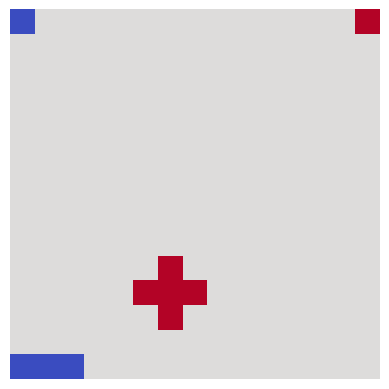

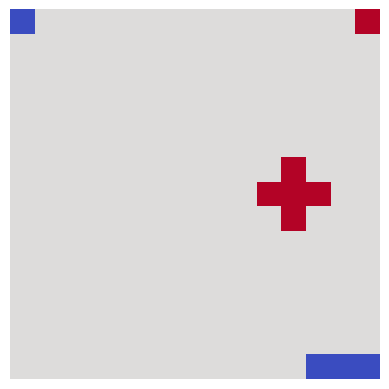

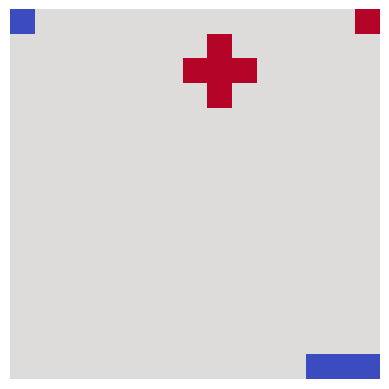

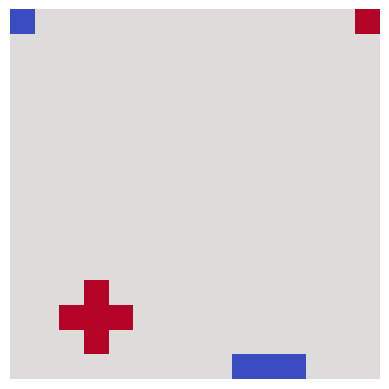

In [ ]:
size = 5
pong = Minipong(level=1, size=size)

# create complete dataset
rows = pong.xymax * pong.xymax * size
columns = pong.size * pong.size

allpix = np.zeros((rows, columns), dtype=int)
alllabels = np.zeros((rows, 3), dtype=int)
j = 0
for x in range(1, pong.xymax + 1):
    for y in range(1, pong.xymax + 1):
        for p in range(pong.zmax + 1):
            allpix[j, :] = pong.to_pix((x, y, p, 0, 0)).flatten(order='C')
            alllabels[j, :] = [x, y, p]
            j += 1

# save all pictures and all labels in random order, two separate files
np.random.seed(10)
neworder = np.random.choice(rows, size=rows, replace=False)
allpix = allpix[neworder,:]
alllabels = alllabels[neworder, :]
np.savetxt('allpix.csv', allpix, delimiter=',', fmt='%d')
np.savetxt('alllabels.csv', alllabels, delimiter=',', fmt='%d')

for i in range(4):
    fig, ax = plt.subplots()
    ax.axis("off")
    plt.imshow(allpix[10+i,:].reshape(15,15), origin='lower' , cmap=plt.cm.coolwarm)
    plt.savefig(f'proto{i+1}.png', dpi=300)
    plt.show()


# number of training and test samples
ntrain = round(0.8 * rows)
ntest = rows - ntrain

trainingpix = allpix[0:ntrain,:]
traininglabels = alllabels[0:ntrain,:]
testingpix = allpix[ntrain:,:]
testinglabels = alllabels[ntrain:,:]

np.savetxt('trainingpix.csv', trainingpix, delimiter=',', fmt='%d')
np.savetxt('traininglabels.csv', traininglabels, delimiter=',', fmt='%d')
np.savetxt('testingpix.csv', testingpix, delimiter=',', fmt='%d')
np.savetxt('testinglabels.csv', testinglabels, delimiter=',', fmt='%d')

**Implementation**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
train_data = pd.read_csv('trainingpix.csv')
test_data = pd.read_csv('testingpix.csv')
train_labels = pd.read_csv('traininglabels.csv')
testing_labels = pd.read_csv('testinglabels.csv')

In [ ]:
# Normalize pixel values
train_data = train_data / 255.0
test_data = test_data / 255.0

# Reshape data (assuming it's flattened)
train_data = train_data.values.reshape(-1, 15, 15, 1)
test_data = test_data.values.reshape(-1, 15, 15, 1)

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(15, 15, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Output layer with 1 neuron for x-coordinate prediction
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])


In [ ]:
print(train_labels.columns)

Index(['9', '9.1', '4'], dtype='object')


In [ ]:
train_labels = pd.read_csv('traininglabels.csv', names=['x', 'y', 'z'])
test_labels = pd.read_csv('testinglabels.csv', names=['x', 'y', 'z'])

In [ ]:
print("Train data shape:", train_data.shape)
print("Train labels shape:", train_labels['x'].shape)
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels['x'].shape)

Train data shape: (675, 15, 15, 1)
Train labels shape: (676,)
Test data shape: (168, 15, 15, 1)
Test labels shape: (169,)


In [ ]:
# Trim the last element from train_labels
train_labels = train_labels.iloc[:675]

# Trim the last element from test_labels
test_labels = test_labels.iloc[:168]

# Now, the shapes should match
print("Train data shape:", train_data.shape)
print("Train labels shape:", train_labels['x'].shape)
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels['x'].shape)


Train data shape: (675, 15, 15, 1)
Train labels shape: (675,)
Test data shape: (168, 15, 15, 1)
Test labels shape: (168,)


In [ ]:
model.fit(train_data, train_labels['x'], epochs=20, batch_size=32, validation_data=(test_data, test_labels['x']))

Epoch 1/20
22/22 [==============================] - 1s 33ms/step - loss: 14.3543 - accuracy: 0.0785 - val_loss: 13.9914 - val_accuracy: 0.0714
Epoch 2/20
22/22 [==============================] - 0s 19ms/step - loss: 14.1175 - accuracy: 0.0785 - val_loss: 13.7505 - val_accuracy: 0.0714
Epoch 3/20
22/22 [==============================] - 0s 18ms/step - loss: 14.2288 - accuracy: 0.0785 - val_loss: 13.7550 - val_accuracy: 0.0714
Epoch 4/20
22/22 [==============================] - 0s 17ms/step - loss: 14.2570 - accuracy: 0.0785 - val_loss: 13.7362 - val_accuracy: 0.0714
Epoch 5/20
22/22 [==============================] - 0s 18ms/step - loss: 14.4905 - accuracy: 0.0785 - val_loss: 13.7376 - val_accuracy: 0.0714
Epoch 6/20
22/22 [==============================] - 0s 22ms/step - loss: 14.4986 - accuracy: 0.0785 - val_loss: 14.3948 - val_accuracy: 0.0714
Epoch 7/20
22/22 [==============================] - 0s 18ms/step - loss: 14.2361 - accuracy: 0.0785 - val_loss: 13.9192 - val_accuracy: 0.0714

In [ ]:
test_loss, test_acc = model.evaluate(test_data, test_labels['x'])
print('Test accuracy:', test_acc)

6/6 [==============================] - 0s 4ms/step - loss: 14.3325 - accuracy: 0.0714
Test accuracy: 0.0714285746216774
